In [113]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

from perlin_noise import PerlinNoise


In [ ]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) 
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

images, labels = next(iter(dataloader))
classes = dataset.classes

imshow(images[0], title=f"Class: {classes[labels[0]]}")
noisy_image = generate_cloud_noise(images[0])
imshow(noisy_image, title="Noise added one")
noisy_image.shape

In [93]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(in_channels, 32)  
        self.enc2 = self.conv_block(32, 64)  

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)  

        self.up1 = self.upsample(128, 64)
        self.dec1 = self.conv_block(128, 64)
        self.up2 = self.upsample(64, 32)
        self.dec2 = self.conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)  # Reduce artifacts
        )

    def forward(self, x):
        e1 = self.enc1(x)  
        e2 = self.enc2(e1)  

        b = self.bottleneck(e2)  

        d1 = self.up1(b)
        d1 = F.interpolate(d1, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d1 = torch.cat([d1, e2], dim=1)  
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        return self.final(d2)  

unet = UNet()


In [94]:

def generate_cloud_noise(image, scale=10, intensity=0.5):
    C, H, W = image.shape  

    perlin = PerlinNoise(octaves=scale)
    
    noise = np.array([[perlin([i / H, j / W]) for j in range(W)] for i in range(H)])
    noise = (noise - noise.min()) / (noise.max() - noise.min())  # Normalize [0,1]

    cloud_noise = torch.tensor(noise, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)

    cloudy_image = image * (1 - intensity) + cloud_noise * intensity
    return cloudy_image.clamp(0, 1)

In [95]:
print(sum(p.numel() for p in unet.parameters()))

437155


In [96]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.9)

transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_root = "./data"
dataset = datasets.ImageFolder(root=data_root, transform=transforms)

batch_size = 4
indices = random.sample(range(len(dataset)), 8000)
subset = Subset(dataset, indices)

train_size = int(0.8 * len(subset))  
val_size = len(subset) - train_size  
train_dataset, val_dataset = random_split(subset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
epochs = 3
log_file = "unet_training_log.txt"

with open(log_file, "w") as f:
    
    for epoch in range(epochs):      
        f.write(f"Epoch : {epoch}\n")
        unet.train()
        train_loss = 0
        counter = 0
        
        for images, _ in train_loader:
            print(counter)  
            images = images.to('cpu')
            cloudy_images = torch.stack([generate_cloud_noise(img) for img in images]).to('cpu')

            optimizer.zero_grad()
            outputs = unet(cloudy_images)

            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            counter += 1
        
        avg_train_loss = train_loss / counter
        f.write(f"Train Loss: {avg_train_loss:.4f}\n")

        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to('cpu')
                cloudy_images = torch.stack([generate_cloud_noise(img) for img in images]).to('cpu')

                outputs = unet(cloudy_images)
                loss = loss_fn(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        f.write(f"Validation Loss: {avg_val_loss:.4f}\n\n")

In [82]:
torch.save(unet.state_dict(), "unet_model.pth")
print("Model saved successfully!")

Model saved successfully!


In [97]:
def extract_edges(image_tensor):
    image_np = image_tensor.permute(1,2,0).cpu().numpy()
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)
    edges = torch.tensor(edges).unsqueeze(0)
    return edges

In [98]:
from torchvision.models.vision_transformer import vit_b_16

vit_model = vit_b_16(pretrained=True)

torch.save(vit_model.state_dict(), "vit_model.pth")
print("ViT model saved successfully!")

c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ViT model saved successfully!


In [103]:
class EdgeAwareViT(nn.Module):
    def __init__(self, num_classes=10, pretrained_path="vit_model.pth"):
        super(EdgeAwareViT, self).__init__()

        self.vit = vit_b_16(pretrained=False)
        
        self.vit.load_state_dict(torch.load(pretrained_path, map_location="cpu"))
        print(f"Loaded ViT weights from {pretrained_path}")

        self.edge_embed = nn.Conv2d(1, 3, kernel_size=3, padding=1)

        self.vit.heads.head = nn.Linear(768, num_classes)

    def forward(self, x):
        edge_maps = torch.stack([extract_edges(img) for img in x], dim=0).to(x.device).float()
        edge_features = self.edge_embed(edge_maps)
        x = x + edge_features
        return self.vit(x)

vit = EdgeAwareViT(num_classes=10, pretrained_path="vit_model.pth")

c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded ViT weights from vit_model.pth


In [114]:
transforms_vit = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_root = "./data"
dataset_vit = datasets.ImageFolder(root=data_root, transform=transforms_vit)

class_indices = {}
for idx, (_, label) in enumerate(dataset_vit.samples):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

num_classes = len(class_indices)
samples_per_class = 16000 // num_classes  # Distribute samples evenly

selected_indices = []
for label, indices in class_indices.items():
    selected_indices.extend(random.sample(indices, min(samples_per_class, len(indices))))

subset_vit = Subset(dataset_vit, selected_indices)

train_size = int(0.8 * len(subset_vit))  
val_size = len(subset_vit) - train_size  
train_dataset_vit, val_dataset_vit = random_split(subset_vit, [train_size, val_size])

batch_size = 4
train_loader_vit = DataLoader(train_dataset_vit, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_vit = DataLoader(val_dataset_vit, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [121]:
device = 'cpu'

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit.to(device)
unet.to(device)  # U-Net is the diffusion model

log_file = "training_log.txt"
with open(log_file, "w") as f:
    f.write("Epoch, Train Loss, Validation Loss, Accuracy\n")

for epoch in range(num_epochs):
    vit.train()
    running_loss = 0.0
    counter = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        print(counter)
        # Resize images to 48x48 for U-Net
        small_images = F.interpolate(images, size=(48, 48), mode="bilinear", align_corners=False)
        
        # Enhance using U-Net
        with torch.no_grad():
            enhanced_images = unet(small_images)

        # Resize back to 224x224 for ViT
        enhanced_images = F.interpolate(enhanced_images, size=(224, 224), mode="bilinear", align_corners=False)
        optimizer.zero_grad()
        outputs = vit(enhanced_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        counter+=1

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    vit.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            small_images = F.interpolate(images, size=(48, 48), mode="bilinear", align_corners=False)
            enhanced_images = unet(small_images)
            enhanced_images = F.interpolate(enhanced_images, size=(224, 224), mode="bilinear", align_corners=False)

            outputs = vit(enhanced_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    with open(log_file, "a") as f:
        f.write(f"{epoch+1}, {avg_train_loss:.4f}, {avg_val_loss:.4f}, {accuracy:.2f}%\n")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [122]:
torch.save(vit.state_dict(), "ea_vit.pth")
print("Edge Aware ViT model saved successfully!")

Edge Aware ViT model saved successfully!


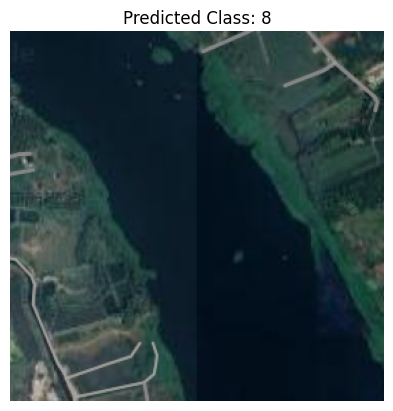

In [135]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)
vit.eval()  # Set model to evaluation mode

unet.to(device)
unet.eval()



transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load a sample image from dataset
sample_image_path = "../Satellite/test_data/test1.png"  # Change path based on dataset structure
image = Image.open(sample_image_path).convert("RGB")

# Apply transforms
input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Resize to 48x48 for U-Net
small_image = torch.nn.functional.interpolate(input_image, size=(48, 48), mode="bilinear", align_corners=False)

# Enhance using U-Net
with torch.no_grad():
    enhanced_image = unet(small_image)

# Resize back to 224x224 for ViT
enhanced_image = torch.nn.functional.interpolate(enhanced_image, size=(224, 224), mode="bilinear", align_corners=False)

# Predict with ViT
with torch.no_grad():
    output = vit(enhanced_image)
    predicted_class = torch.argmax(output, dim=1).item()

# Display result
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()


In [134]:
import torch

# Define paths to save models
vit_save_path = "./models/ea_vit_model.pth"
unet_save_path = "./models/unet_model.pth"

# Save model state dicts
torch.save(vit.state_dict(), vit_save_path)
torch.save(unet.state_dict(), unet_save_path)

print(f"Models saved successfully at:\n{vit_save_path}\n{unet_save_path}")


Models saved successfully at:
./models/ea_vit_model.pth
./models/unet_model.pth


In [136]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
vit = EdgeAwareViT().to(device)
unet = UNet().to(device)

# Define paths to saved models
vit_path = "./models/ea_vit_model.pth"
unet_path = "./models/unet_model.pth"

# Load trained weights
vit.load_state_dict(torch.load(vit_path, map_location=device))
unet.load_state_dict(torch.load(unet_path, map_location=device))

# Set models to evaluation mode
vit.eval()
unet.eval()

print("✅ Models loaded successfully and set to evaluation mode!")


c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prith\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded ViT weights from vit_model.pth
✅ Models loaded successfully and set to evaluation mode!


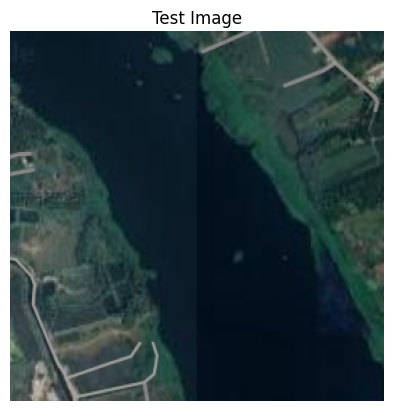

In [137]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to match training
])

# Load a test image
sample_image_path = "./test_data/test1.png"  # Change if needed
image = Image.open(sample_image_path).convert("RGB")

# Apply transformations
input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Display the original image
plt.imshow(image)
plt.title("Test Image")
plt.axis("off")
plt.show()


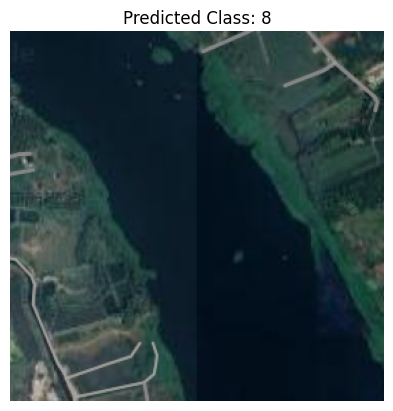

✅ Predicted Class: 8


In [138]:
# Resize to 48x48 for U-Net
small_image = torch.nn.functional.interpolate(input_image, size=(48, 48), mode="bilinear", align_corners=False)

# Enhance image using U-Net
with torch.no_grad():
    enhanced_image = unet(small_image)

# Resize back to 224x224 for ViT
enhanced_image = torch.nn.functional.interpolate(enhanced_image, size=(224, 224), mode="bilinear", align_corners=False)

# Ensure the enhanced image has 3 channels (if grayscale)
if enhanced_image.shape[1] == 1:
    enhanced_image = enhanced_image.repeat(1, 3, 1, 1)

# Predict with ViT
with torch.no_grad():
    output = vit(enhanced_image)
    predicted_class = torch.argmax(output, dim=1).item()

# Display result
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()

print(f"✅ Predicted Class: {predicted_class}")
